In [1]:
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [9]:
p=Path('/content/drive/MyDrive/animals')
dirs=p.glob("*")

image_data=[]
labels=[]

label_dict={}
label_to_animals={}
counter=0
for i in dirs:
    label=str(i).split("\\")[-1]
    label_dict[label]=counter
    label_to_animals[counter]=label
    
    print(i)
    count=0
    
    for img_path in i.glob("*.jpg"):
        img = image.load_img(img_path,target_size=(108,108))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(counter)
        count +=1
        
    print(count)
    counter +=1

/content/drive/MyDrive/animals/panda
1000
/content/drive/MyDrive/animals/cats
1000
/content/drive/MyDrive/animals/dogs
1000


In [10]:
import numpy as np

In [11]:
X=np.array(image_data)
Y=np.array(labels)

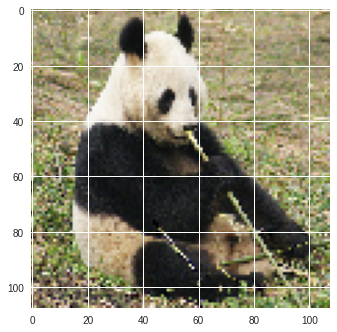

In [12]:
plt.imshow(X[0]/255)

In [13]:
def drawimage(image,label):
    plt.style.use('seaborn')
    plt.title(label_to_animals[label])
    plt.imshow(image)
    plt.show()

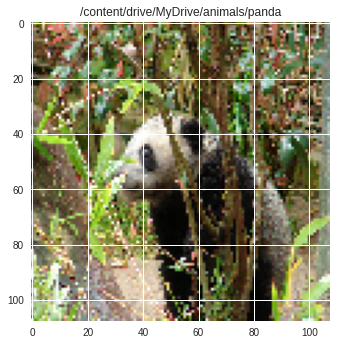

In [14]:
drawimage(X[344]/255,Y[344])


In [37]:
import random
random.seed(10)

In [38]:
#Shuffle our data
from sklearn.utils import shuffle
X,Y = shuffle(X,Y,random_state=2)

#Normalisation
X = X/255.0

In [39]:
### Create Training and Testing Set
X_ = np.array(X)
Y_ = np.array(Y)

#Training Set
X = X_[:353,:]
Y = Y_[:353]

#Test Set
XTest = X_[353:,:]
YTest = Y_[353:]

print(X.shape,Y.shape)
print(XTest.shape,YTest.shape)

(353, 34992) (353,)
(0, 34992) (0,)


In [18]:
class NeuralNetwork:
    
    def __init__(self,input_size,layers,output_size):
        np.random.seed(0)
        
        model = {} #Dictionary
        
        #First Layer
        model['W1'] = np.random.randn(input_size,layers[0])
        model['b1'] = np.zeros((1,layers[0]))
        
        #Second Layer
        model['W2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1,layers[1]))
        
        #Third Layer
        model['W3'] = np.random.randn(layers[1],layers[2])
        model['b3'] = np.zeros((1,layers[2]))
        
        #Output Layer
        model['W4'] = np.random.randn(layers[2],output_size)
        model['b4'] = np.zeros((1,output_size))
        
        self.model = model
        self.activation_outputs = None
    
    def forward(self,x):
        
        W1,W2,W3,W4 = self.model['W1'],self.model['W2'],self.model['W3'],self.model['W4']
        b1, b2, b3,b4 = self.model['b1'],self.model['b2'],self.model['b3'],self.model['b4']
        
        z1 = np.dot(x,W1) + b1
        a1 = np.tanh(z1) 
        
        z2 = np.dot(a1,W2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2,W3) + b3
        a3 = np.tanh(z3)
        
        z4 = np.dot(a3,W4) + b4
        y_ = softmax(z4)
        
        self.activation_outputs = (a1,a2,a3,y_)
        return y_
        
    def backward(self,x,y,learning_rate=0.001):
        W1,W2,W3,W4 = self.model['W1'],self.model['W2'],self.model['W3'],self.model['W4']
        b1, b2, b3,b4 = self.model['b1'],self.model['b2'],self.model['b3'],self.model['b4']
        m = x.shape[0]
        
        a1,a2,a3,y_ = self.activation_outputs
        
        delta4 = y_ - y
        dw4 = np.dot(a3.T,delta4)
        db4 = np.sum(delta4,axis=0)
        
        delta3 = (1-np.square(a3))*np.dot(delta4,W4.T)
        dw3 = np.dot(a2.T,delta3)
        db3 = np.sum(delta3,axis=0)
        
        delta2 = (1-np.square(a2))*np.dot(delta3,W3.T)
        dw2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis=0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2,W2.T)
        dw1 = np.dot(X.T,delta1)
        db1 = np.sum(delta1,axis=0)
        
        
        #Update the Model Parameters using Gradient Descent
        self.model["W1"]  -= learning_rate*dw1
        self.model['b1']  -= learning_rate*db1
        
        self.model["W2"]  -= learning_rate*dw2
        self.model['b2']  -= learning_rate*db2
        
        self.model["W3"]  -= learning_rate*dw3
        self.model['b3']  -= learning_rate*db3
        
        self.model["W4"]  -= learning_rate*dw4
        self.model['b4']  -= learning_rate*db4
        
        # :)
        
    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out,axis=1)
    
    def summary(self):
        W1,W2,W3,W4 = self.model['W1'],self.model['W2'],self.model['W3'],self.model['W4']
        a1,a2,a3,y_ = self.activation_outputs
        
        print("W1 ",W1.shape)
        print("A1 ",a1.shape)

def softmax(a):
    e_pa = np.exp(a) #Vector
    ans = e_pa/np.sum(e_pa,axis=1,keepdims=True)
    return ans    

In [19]:
def loss(y_oht,p):
    l = -np.mean(y_oht*np.log(p))
    return l

def one_hot(y,depth):
    
    m = y.shape[0]
    y_oht = np.zeros((m,depth))
    y_oht[np.arange(m),y] = 1
    return y_oht

In [20]:
def train(X,Y,model,epochs,learning_rate,logs=True):
    training_loss = []
    
    classes = 3
    Y_OHT = one_hot(Y,classes)
    
    for ix in range(epochs):
        
        Y_ = model.forward(X)
        l = loss(Y_OHT,Y_)
        
        model.backward(X,Y_OHT,learning_rate)
        training_loss.append(l)
        if(logs and ix%50==0):
            print("Epoch %d Loss %.4f"%(ix,l))
            
            
    
    return training_loss

In [24]:
model = NeuralNetwork(input_size=34992,layers=[200,50,20],output_size=3)

In [25]:
X = X.reshape(X.shape[0],-1)
print(X.shape)

XTest = XTest.reshape(XTest.shape[0],-1)
print(XTest.shape)

(353, 34992)
(2647, 34992)


In [26]:
l = train(X,Y,model,1000,0.0005)

Epoch 0 Loss 1.0848
Epoch 50 Loss 0.2464
Epoch 100 Loss 0.1472
Epoch 150 Loss 0.0876
Epoch 200 Loss 0.1101
Epoch 250 Loss 0.1039
Epoch 300 Loss 0.0413
Epoch 350 Loss 0.0312
Epoch 400 Loss 0.0254
Epoch 450 Loss 0.0214
Epoch 500 Loss 0.0183
Epoch 550 Loss 0.0160
Epoch 600 Loss 0.0122
Epoch 650 Loss 0.0105
Epoch 700 Loss 0.0094
Epoch 750 Loss 0.0084
Epoch 800 Loss 0.0077
Epoch 850 Loss 0.0071
Epoch 900 Loss 0.0066
Epoch 950 Loss 0.0062


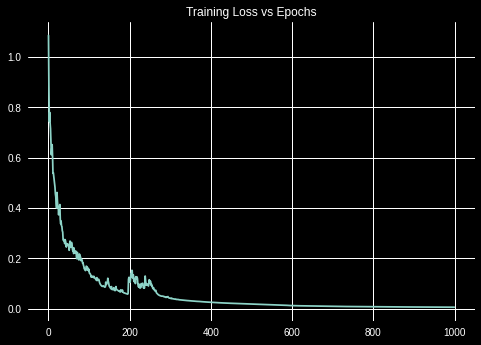

In [27]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.title("Training Loss vs Epochs")
plt.plot(l)

plt.show()

In [28]:
# Accuracy 
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc
    
print("Train Accuracy: %.4f  :)"%getAccuracy(X,Y,model))
print("Test Accuracy: %.4f :("%getAccuracy(XTest,YTest,model))

Train Accuracy: 1.0000  :)
Test Accuracy: 0.4299 :(


In [30]:
print('Enter the image path: ')
img_path=input()

img = image.load_img(img_path,target_size=(108,108))
img = image.img_to_array(img)
print(img.shape)
img= img.reshape(1,-1)

y=model.predict(img)
for i in label_to_animals.keys():
    print(i)
    if i==y:
        print(label_to_animals[i])
        break

Enter the image path: 
/content/drive/MyDrive/animals/cats/cats_00001.jpg
(108, 108, 3)
0
1
2
/content/drive/MyDrive/animals/dogs
